# Load data

In [4]:
from pathlib import Path
from scipy import sparse
import pandas as pd
import numpy as np

DATA_DIR = Path("/home/ubuntu/ml4fg-final-project/COVID_single_cell_datasets")

# pull genes X cells counts matrix
X = sparse.load_npz(DATA_DIR /"counts.npz")
X = X.T.tocsr()

# pull names of which genes are in the counts matrix
var = pd.read_csv(DATA_DIR /"GSE158055_covid19_features.tsv.gz", sep="\t", header=None)
var.columns = ["gene"]
var.index = var["gene"]

# metadata for each of the ~1.5M cells, including which individual each cell is from
cell_meta = pd.read_csv(DATA_DIR / "GSE158055_cell_annotation.csv.gz")
cell_meta.index = cell_meta["cellName"]
cell_meta["sampleID"] = cell_meta["sampleID"].str.strip()
cell_meta["cellName"] = cell_meta["cellName"].str.strip()

# metadata for the samples (individuals), including their covid status
sample_metadata = pd.read_csv(DATA_DIR / "GSE158055_sample_metadata.tsv", sep="\t")
sample_metadata["Sample name"] = sample_metadata["Sample name"].str.strip()
sample_metadata = sample_metadata.rename(
    columns={"characteristics: SARS-CoV-2": "covid_status",
             "Sample name" : "sampleID", 
             "characteristics: CoVID-19 severity": "covid_severity"}
)
sample_metadata = sample_metadata[["sampleID", "covid_status", "covid_severity"]]

# merge cell metadata with individual metadata
n_cells_meta = len(cell_meta)
cell_meta = cell_meta.copy()
cell_meta["row_index"] = np.arange(n_cells_meta, dtype=np.int64)
obs = cell_meta.merge(
    sample_metadata,
    left_on="sampleID", right_on="sampleID", how="left"
)
obs.index = obs["cellName"]

# Preprocessing

In [5]:
import anndata as ad
import scanpy as sc

adata = ad.AnnData(X=X, obs=obs, var=var)
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

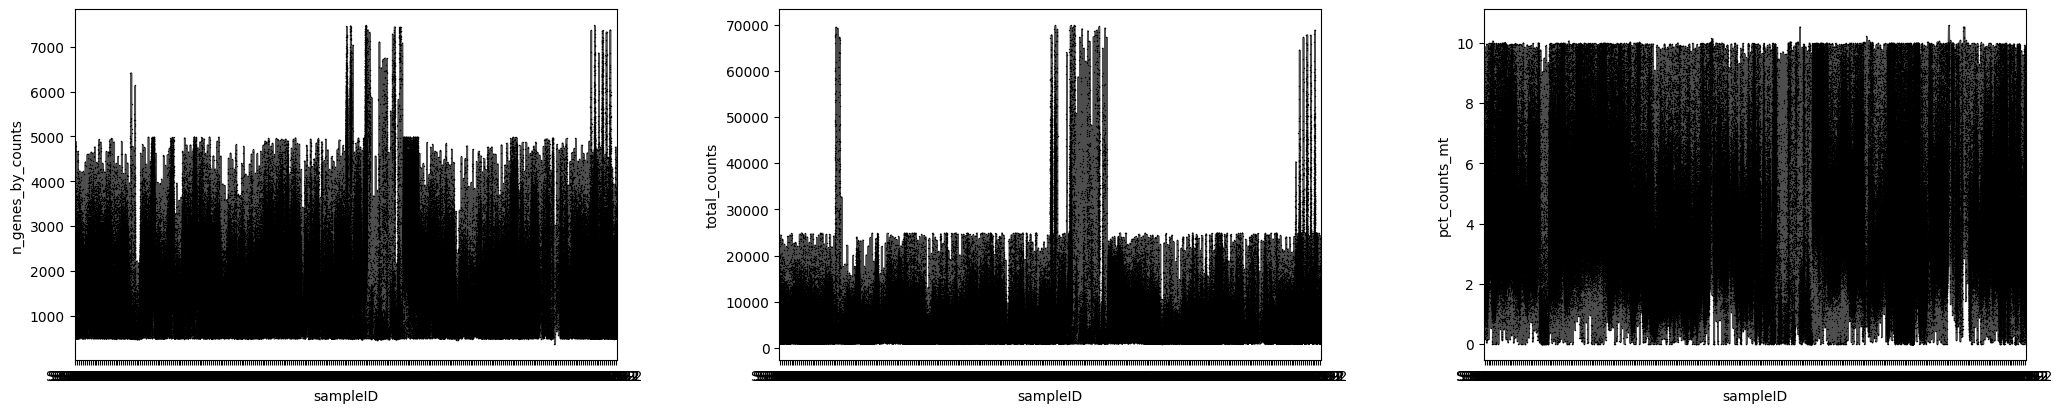

In [22]:
# full dataset visualization
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    groupby="sampleID"
)

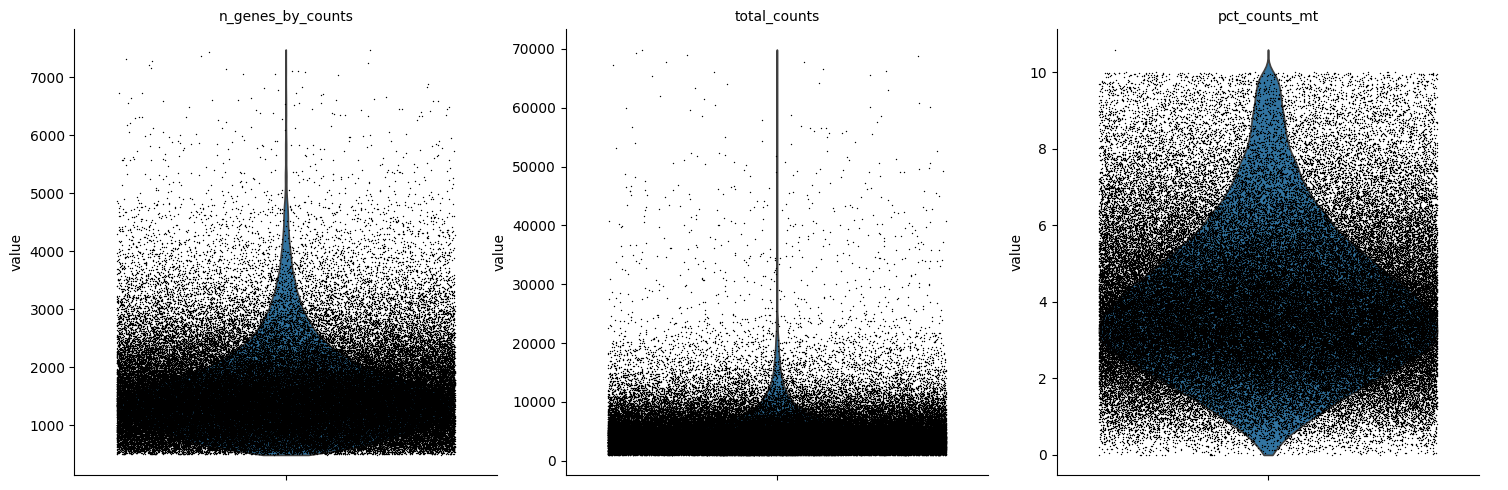

In [ ]:
# violin plots for random selection of cells
idx = np.random.choice(adata.n_obs, size=100000, replace=False)
sc.pl.violin(
    adata[idx],
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    multi_panel=True,
    jitter=0.4,
)

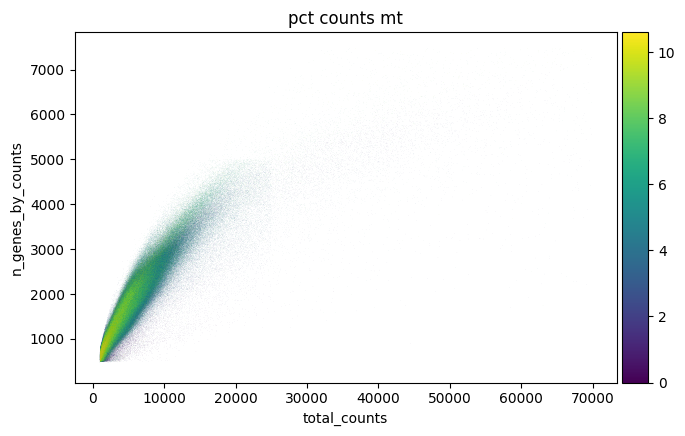

In [24]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [6]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

### Feature Selection: Highly Variable Genes

In [26]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sampleID")

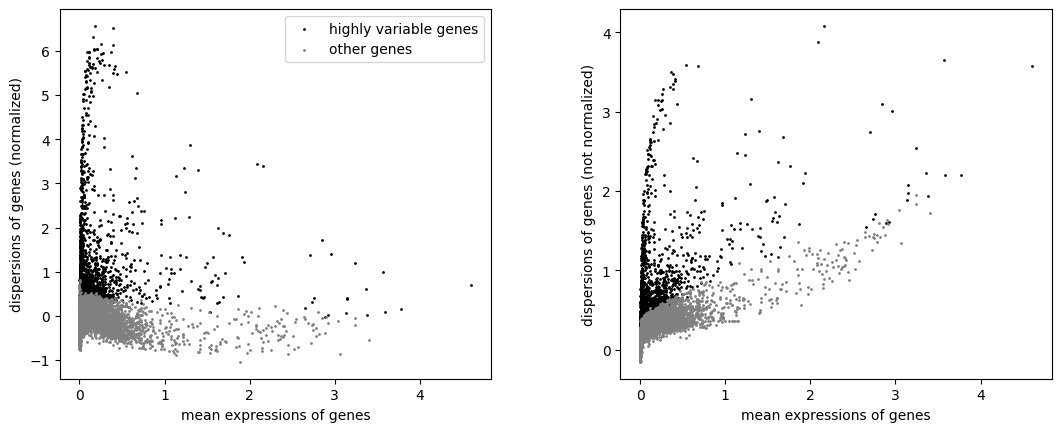

In [27]:
sc.pl.highly_variable_genes(adata)

### Dimensionality Reduction: PCA

#### Run PCA on ALL genes

In [7]:
pca_dim = 50

In [8]:
sc.tl.pca(adata, n_comps=pca_dim)

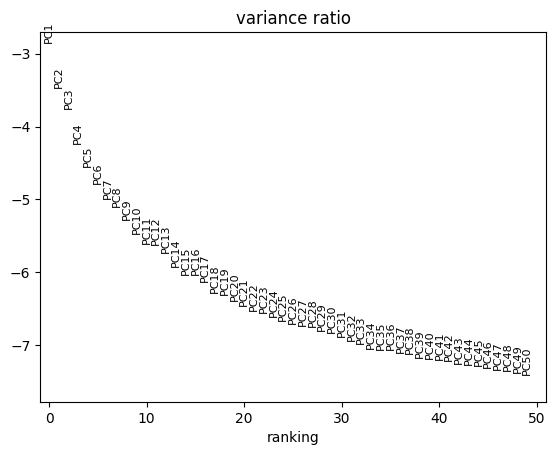

In [ ]:
sc.pl.pca_variance_ratio(adata, n_pcs=pca_dim, log=True)

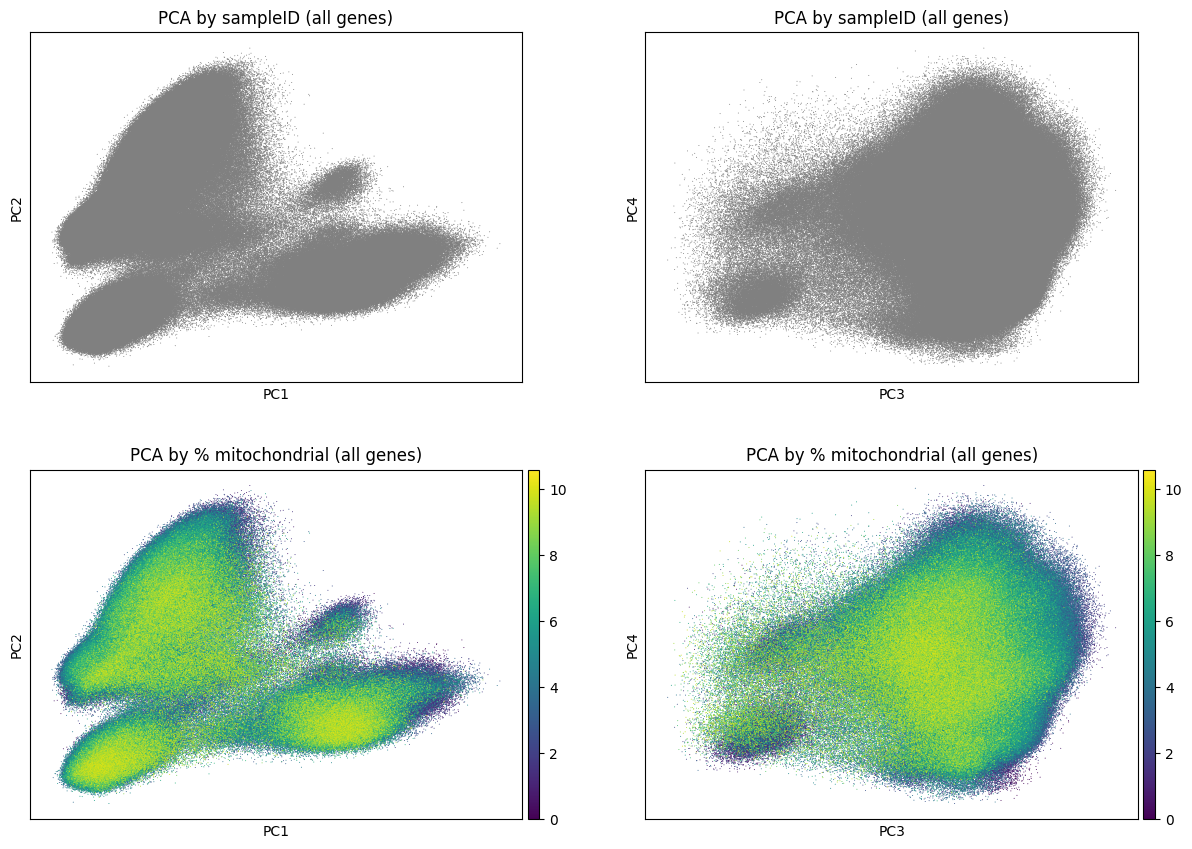

In [ ]:
sc.pl.pca(
    adata,
    color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    legend_loc=None, 
    title=["PCA by sampleID (all genes)", "PCA by sampleID (all genes)", "PCA by % mitochondrial (all genes)", "PCA by % mitochondrial (all genes)"]
)

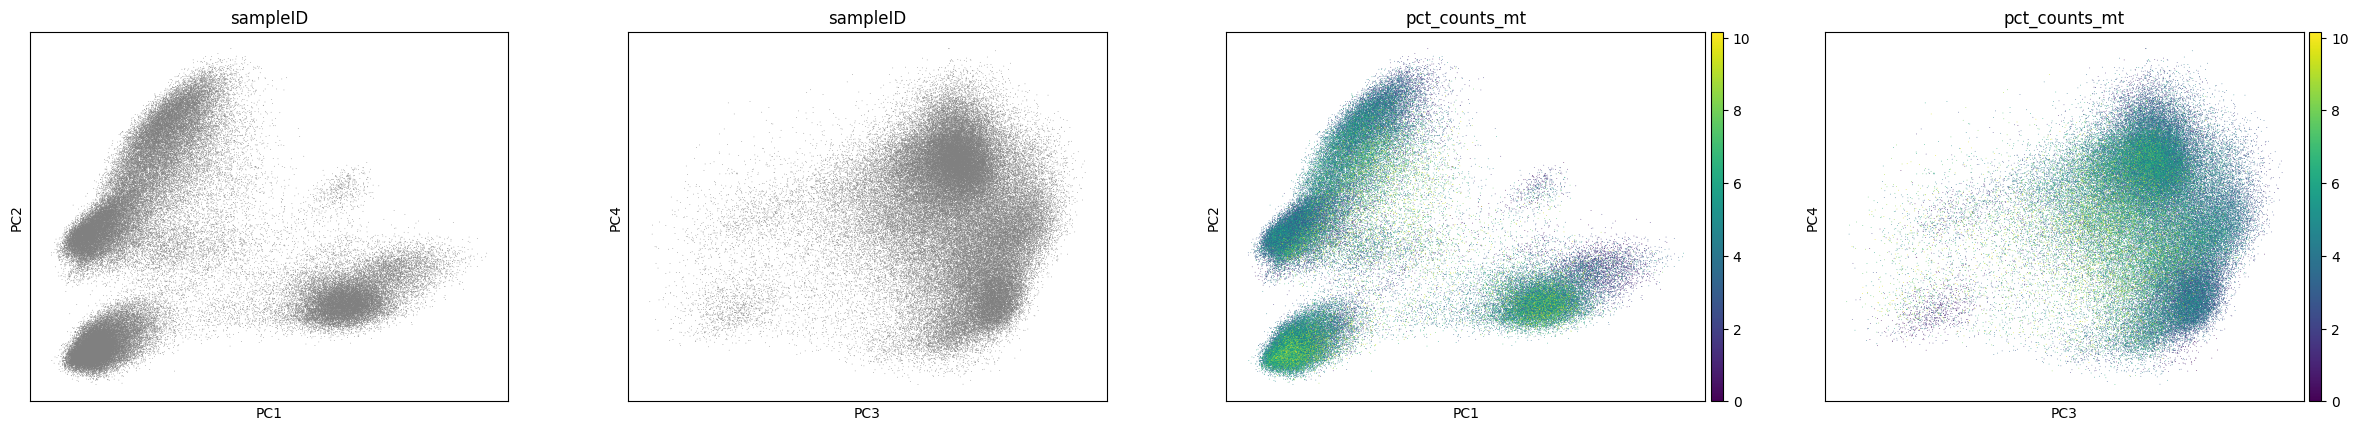

In [ ]:
sc.pl.pca(adata[adata.obs.sample(100000).index], color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)], legend_loc=None)


UMAP of PCA Visualization

In [ ]:
sc.pp.neighbors(adata)

In [11]:
sc.tl.umap(adata)

<Axes: title={'center': 'PCA Across All Genes UMAP'}, xlabel='UMAP1', ylabel='UMAP2'>

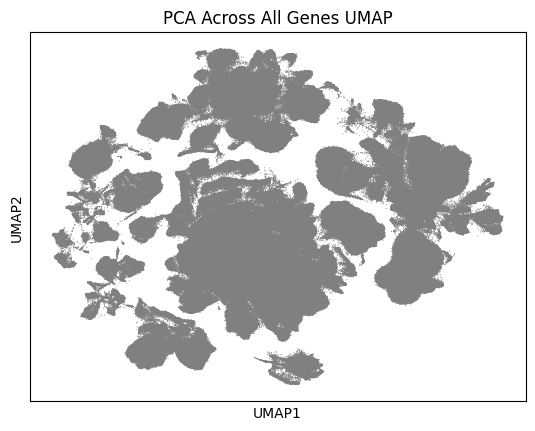

In [12]:
sc.pl.umap(
    adata,
    color="sampleID",
    # Setting a smaller point size to get prevent overlap
    size=2,
    title="PCA Across All Genes UMAP", show=False, legend_loc=None
)

#### Run PCA on Highly Variable Genes

In [37]:
adata_hvg = adata[:, adata.var['highly_variable']].copy()

In [ ]:
sc.tl.pca(adata_hvg, n_comps=pca_dim)

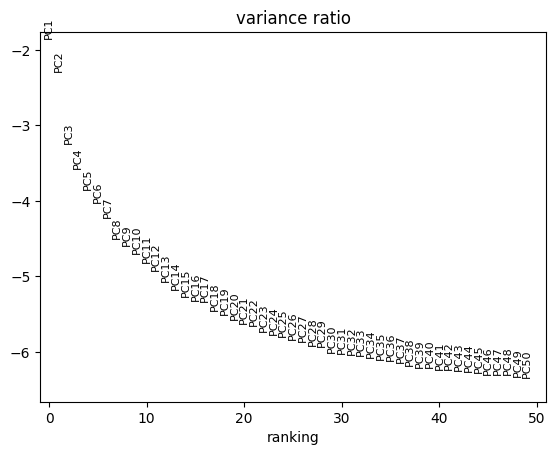

In [ ]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=pca_dim, log=True)

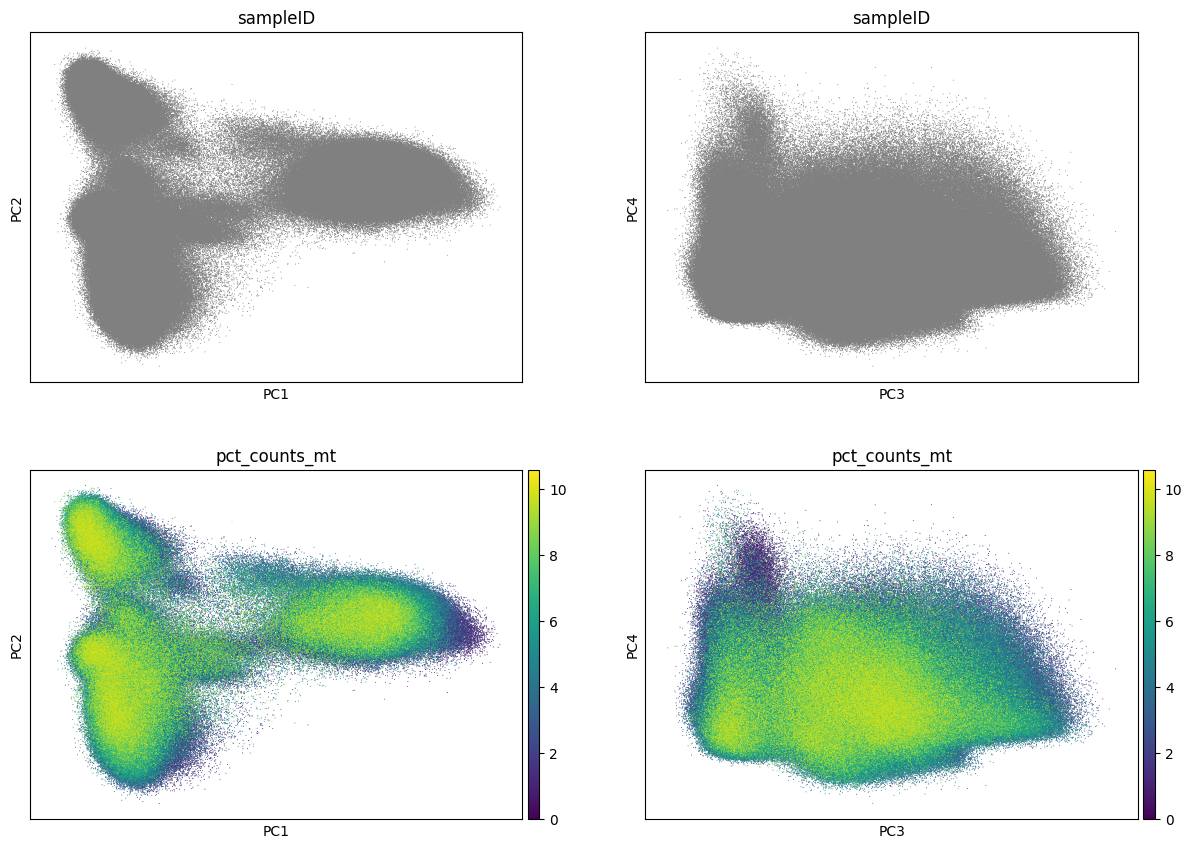

In [40]:
sc.pl.pca(
    adata_hvg,
    color=["sampleID", "sampleID", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (2, 3), (0, 1), (2, 3)],
    ncols=2,
    size=2,
    legend_loc=None
)

UMAP of PCA Visualization

In [ ]:
sc.pp.neighbors(adata_hvg)

In [ ]:
sc.tl.umap(adata_hvg)

In [ ]:
sc.pl.umap(
    adata_hvg,
    color="sampleID",
    # Setting a smaller point size to get prevent overlap
    size=2,
)

Conclusion: looks really similar, use pca on full set of genes as the model input

# Prepare Model Input

In [9]:
obs = adata.obs.copy()
assert "sampleID" in obs.columns
assert "covid_status" in obs.columns

In [8]:
obs.columns

Index(['cellName', 'sampleID', 'celltype', 'majorType', 'row_index',
       'covid_status', 'covid_severity', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'],
      dtype='object')

In [10]:
import data_sampler

indiv_df = (
    obs.groupby("sampleID")["covid_status"]
       .apply(data_sampler.get_unique_label)
       .reset_index()
       )

# Keep only individuals with known (positive/negative) status
indiv_df = indiv_df.dropna(subset=["covid_status"])
indiv_df["covid_status"] = indiv_df["covid_status"].str.lower()
print(indiv_df["covid_status"].value_counts())

covid_status
positive    256
negative     28
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import train_test_split

# split individuals into train/val + test setse
train_ids, temp_ids = train_test_split(
    indiv_df["sampleID"].values,
    test_size=0.2,  # 80% train, 20% (val+test)
    stratify=indiv_df["covid_status"].values,
    random_state=42,
)

temp_df = indiv_df[indiv_df["sampleID"].isin(temp_ids)]

# split individuals into val and test sets
val_ids, test_ids = train_test_split(
    temp_df["sampleID"].values,
    test_size=0.5,  # 10% val, 10% test overall
    stratify=temp_df["covid_status"].values,
    random_state=42,
)

In [12]:
train_ids = set(train_ids)
val_ids = set(val_ids)
test_ids = set(test_ids)

print(f"Train individuals: {len(train_ids)}")
print(f"Val individuals:   {len(val_ids)}")
print(f"Test individuals:  {len(test_ids)}")

Train individuals: 227
Val individuals:   28
Test individuals:  29


In [13]:
train_mask = adata.obs["sampleID"].isin(train_ids)
val_mask   = adata.obs["sampleID"].isin(val_ids)
test_mask  = adata.obs["sampleID"].isin(test_ids)

adata_train = adata[train_mask].copy()
adata_val   = adata[val_mask].copy()
adata_test  = adata[test_mask].copy()

print(adata_train.shape, adata_val.shape, adata_test.shape)

(1163659, 27894) (155093, 27894) (143950, 27894)


In [14]:
import torch 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
assert device.type == "cuda" # ensure we are using GPU
OUTPUT_DIR = Path("/home/ubuntu/ml4fg-final-project/output_models")

Using device: cuda


# 50 Epochs, Sequence Length=64

### Initialize and Train Model

In [15]:
import importlib

In [22]:
pca_dim = 50
d_model = 256
n_layers = 6
n_heads = 4
d_hid = 512
dropout = 0.1
n_components = 8
max_seq_len = 256
batch_size = 32
lr = 1e-4

In [ ]:
import train 
importlib.reload(train)
from train import train_model

_, best_model_state_50epochs_64seqlen = train_model(
    adata_train,
    adata_val,
    adata_test,
    device=device,
    seq_len=64, # SEQUENCE LENGTH
    pca_dim = pca_dim, 
    d_model = d_model,
    n_layers = n_layers,
    n_heads = n_heads,
    d_hid = d_hid,
    dropout = dropout,
    n_components = n_components,
    max_seq_len = max_seq_len,
    batch_size = batch_size,
    lr = lr,
    epochs = 50, # 50 EPOCHS
    OUTPUT_DIR = Path("/home/ubuntu/ml4fg-final-project/output_models")
    )

number of params: 3383336


| end of epoch   1 | time: 64.27s | train loss 64.7176 | val loss 65.4918
New best model at epoch 1 with val loss=65.4918
| end of epoch   2 | time: 65.28s | train loss 60.3997 | val loss 65.4569
New best model at epoch 2 with val loss=65.4569
| end of epoch   3 | time: 64.94s | train loss 59.4678 | val loss 65.6459
| end of epoch   4 | time: 64.94s | train loss 58.8763 | val loss 65.7087
| end of epoch   5 | time: 65.71s | train loss 58.5241 | val loss 65.7153
| end of epoch   6 | time: 65.16s | train loss 58.1930 | val loss 65.8003
| end of epoch   7 | time: 64.52s | train loss 58.0207 | val loss 66.1086
| end of epoch   8 | time: 65.09s | train loss 57.8675 | val loss 66.1202
| end of epoch   9 | time: 67.51s | train loss 57.7877 | val loss 66.1261
| end of epoch  10 | time: 65.19s | train loss 57.7301 | val loss 66.2170
| end of epoch  11 | time: 64.76s | train loss 57.6699 | val loss 66.1245
| end of epoch  12 | time: 66.00s | train loss 57.6093 | val loss 66.6013
| end of epoch  

### Visualize Results

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


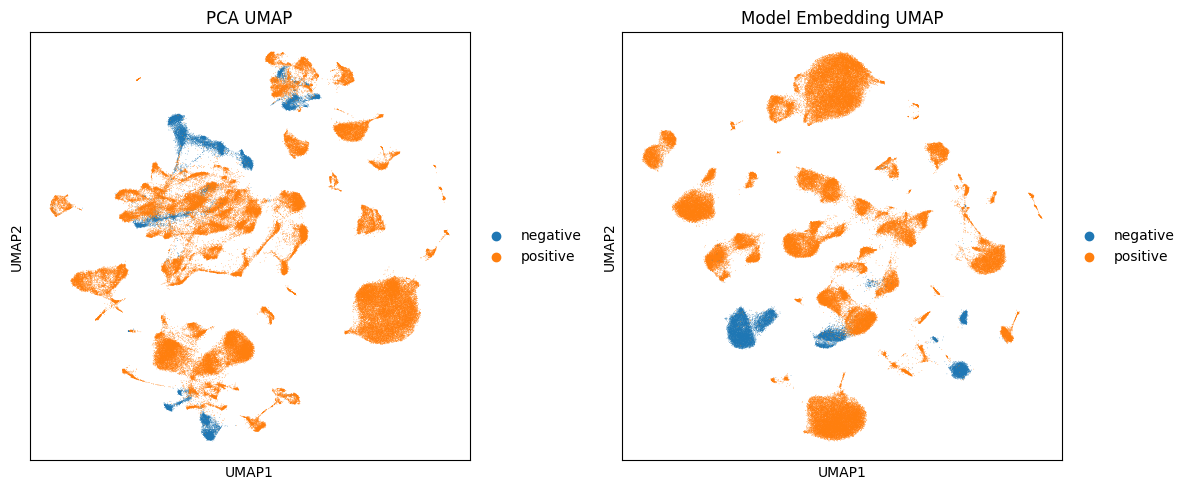

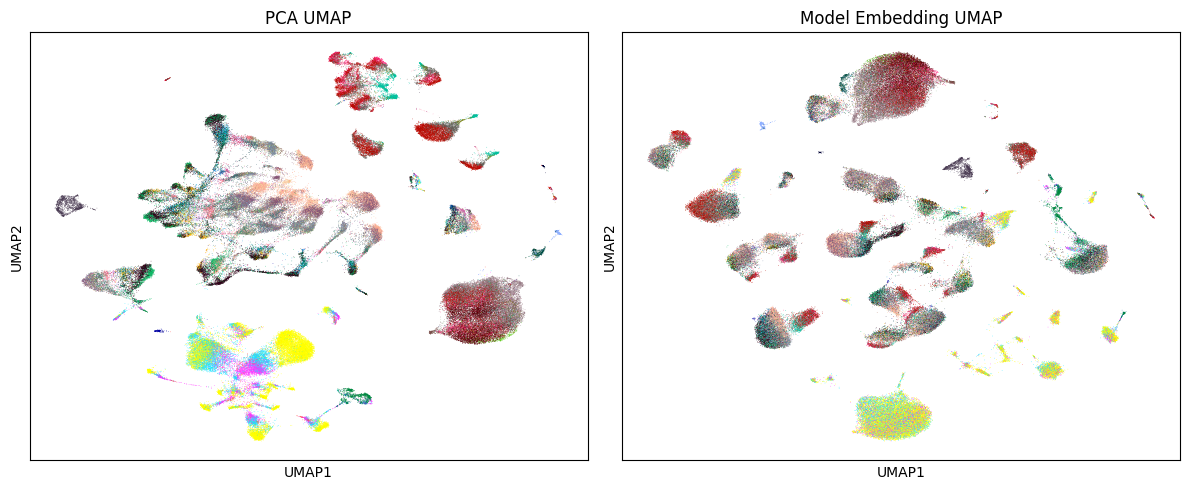

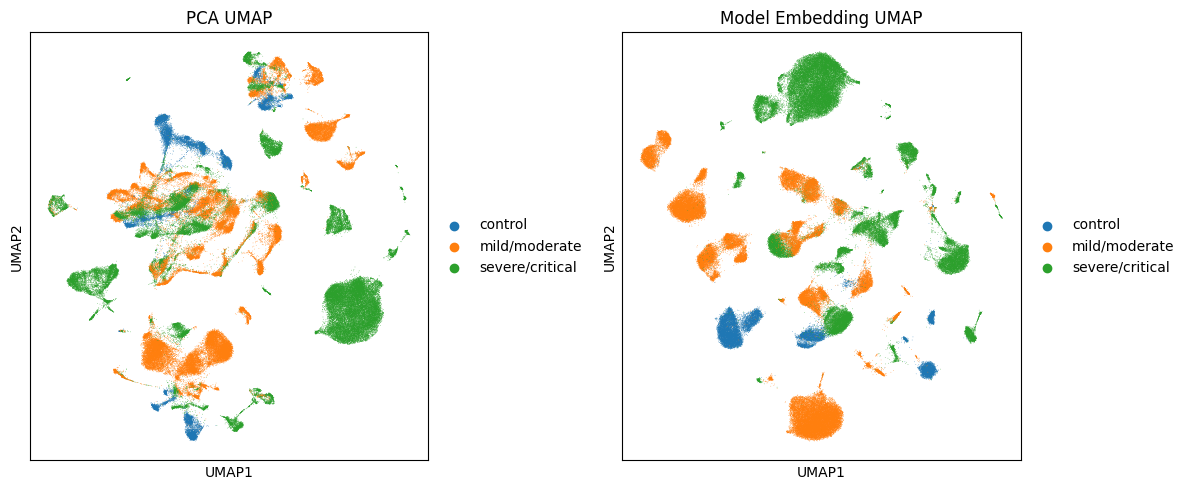

In [23]:
from evaluate import visualize_results
from models import AutoregressiveCellModel

best_model_50epochs_64seqlen = AutoregressiveCellModel(
        pca_dim = pca_dim,
        d_model=d_model,
        n_layers = n_layers,
        n_heads = n_heads,
        d_hid = d_hid,
        dropout = dropout,
        n_components = n_components,
        max_seq_len = max_seq_len,
        ).to(device)

checkpoint = torch.load(OUTPUT_DIR / f"best_model_50epochs_64seqlen.pt", map_location=device)
best_model_50epochs_64seqlen.load_state_dict(checkpoint)
visualize_results(adata_test, best_model_50epochs_64seqlen)

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


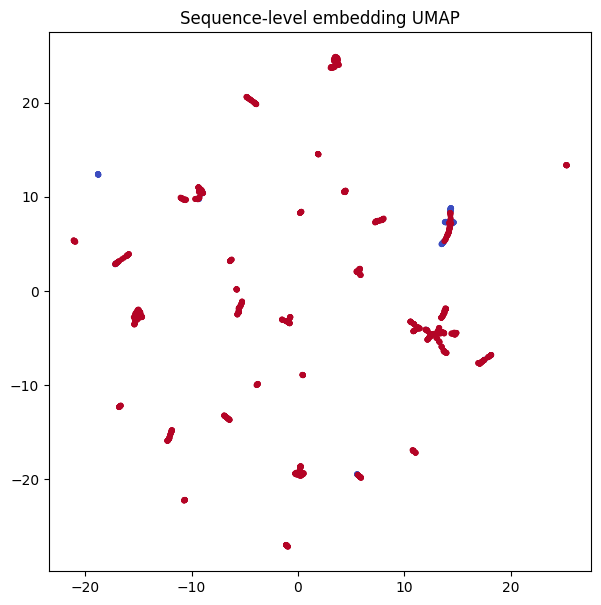

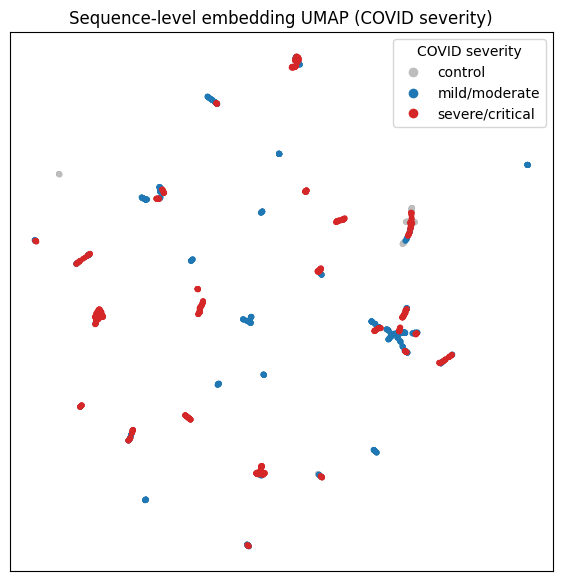

In [26]:
from evaluate import compute_sequence_embeddings
from covid_prediction import covid_embeddings_visualize

# show for all individuals instead of just test set
embs_50epochs_64seqlen, emb_labels_50epochs_64seqlen = compute_sequence_embeddings(best_model_50epochs_64seqlen, adata)
covid_embeddings_visualize(adata, embs_50epochs_64seqlen, emb_labels_50epochs_64seqlen)

### COVID Severity Prediction

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== SEVERITY (Multiclass) ===
PCA   ROC-AUC: 0.8569854316586342
MODEL ROC-AUC: 0.8980936819172114


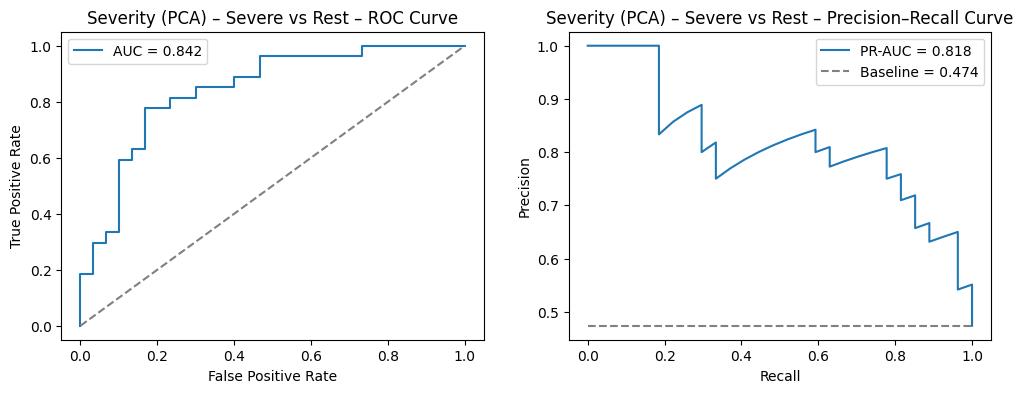

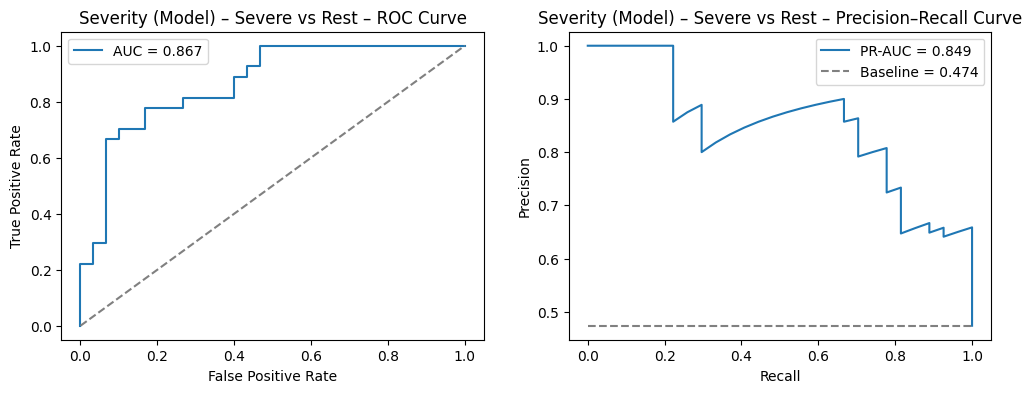

In [27]:
from covid_prediction import covid_severity_prediction

covid_severity_prediction(adata, emb_labels_50epochs_64seqlen, embs_50epochs_64seqlen)

# 100 Epochs, Sequence Length=64

In [28]:
_, best_model_state_100epochs_64seqlen = train_model(
    adata_train,
    adata_val,
    adata_test,
    device=device,
    seq_len=64, # SEQUENCE LENGTH
    pca_dim = 50, 
    d_model = 256,
    n_layers = 6,
    n_heads = 4,
    d_hid = 512,
    dropout = 0.1,
    n_components = 8,
    max_seq_len = 256,
    batch_size = 32,
    lr = 1e-4,
    epochs = 100, # 100 EPOCHS
    OUTPUT_DIR = Path("/home/ubuntu/ml4fg-final-project/output_models")
    )

number of params: 3383336


| end of epoch   1 | time: 65.59s | train loss 64.1219 | val loss 65.4959
New best model at epoch 1 with val loss=65.4959
| end of epoch   2 | time: 64.74s | train loss 60.2429 | val loss 65.4955
New best model at epoch 2 with val loss=65.4955
| end of epoch   3 | time: 66.06s | train loss 59.4783 | val loss 65.9063
| end of epoch   4 | time: 65.90s | train loss 59.0987 | val loss 65.9230
| end of epoch   5 | time: 66.35s | train loss 58.7965 | val loss 66.1016
| end of epoch   6 | time: 63.71s | train loss 58.6484 | val loss 66.3739
| end of epoch   7 | time: 66.00s | train loss 58.4936 | val loss 66.4461
| end of epoch   8 | time: 65.36s | train loss 58.3823 | val loss 66.5419
| end of epoch   9 | time: 63.96s | train loss 58.2186 | val loss 66.7386
| end of epoch  10 | time: 64.94s | train loss 58.1354 | val loss 66.6725
| end of epoch  11 | time: 65.28s | train loss 58.0549 | val loss 66.6491
| end of epoch  12 | time: 64.76s | train loss 57.9960 | val loss 66.8293
| end of epoch  

### Visualize Results

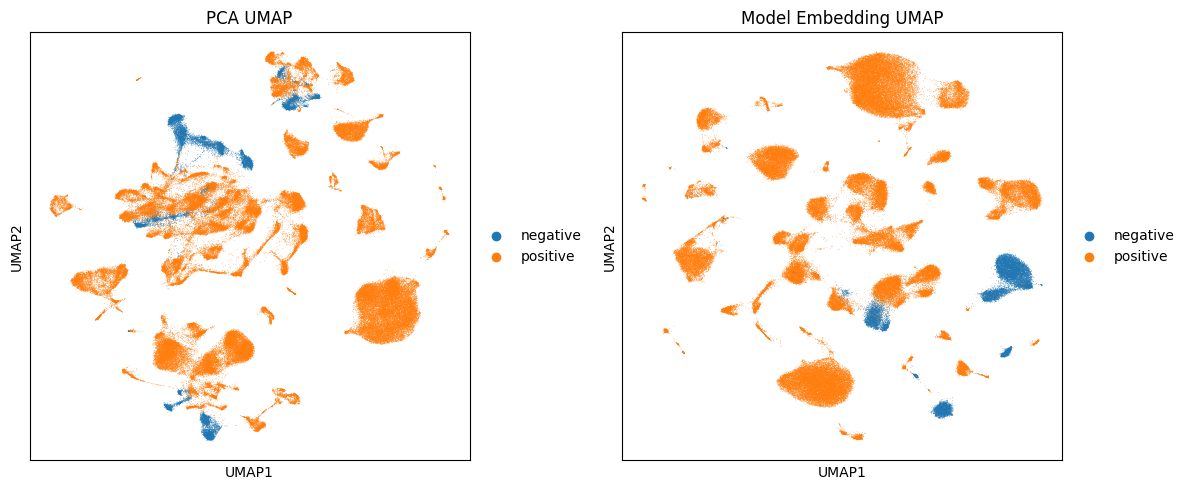

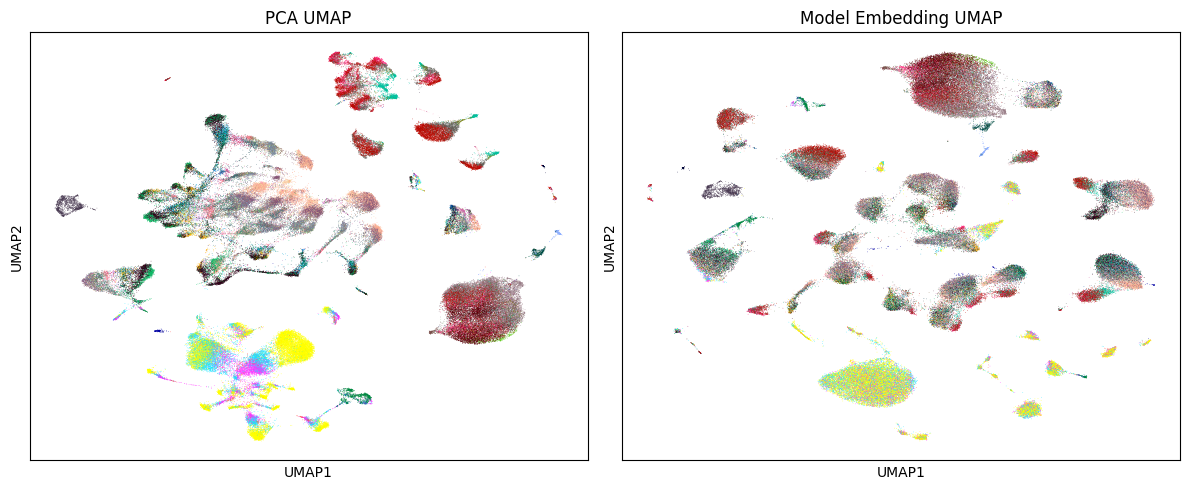

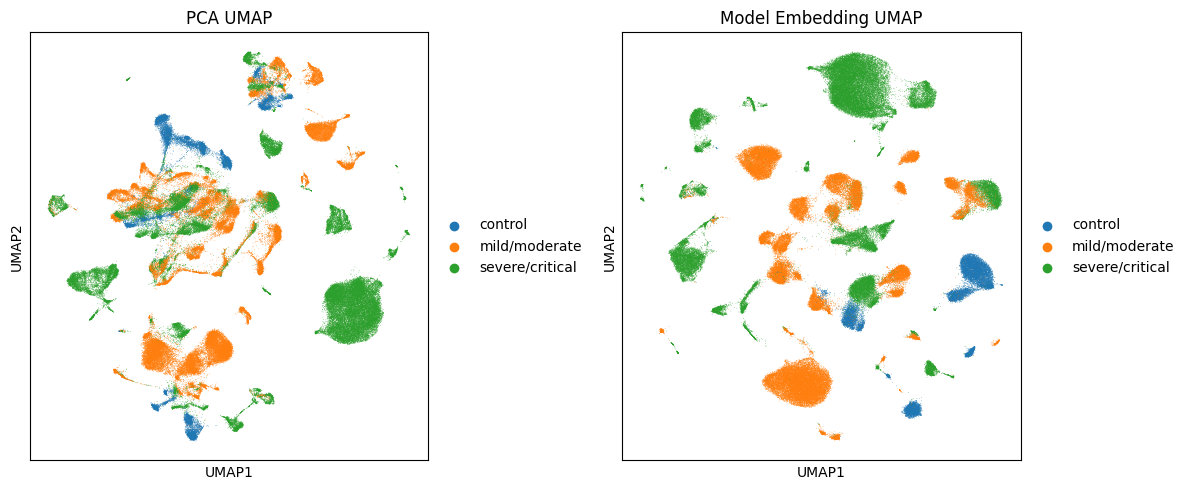

In [31]:
best_model_100epochs_64seqlen = AutoregressiveCellModel(
        pca_dim = pca_dim,
        d_model=d_model,
        n_layers = n_layers,
        n_heads = n_heads,
        d_hid = d_hid,
        dropout = dropout,
        n_components = n_components,
        max_seq_len = max_seq_len,
        ).to(device)

checkpoint = torch.load(OUTPUT_DIR / f"best_model_100epochs_64seqlen.pt", map_location=device)
best_model_100epochs_64seqlen.load_state_dict(checkpoint)

visualize_results(adata_test, best_model_100epochs_64seqlen)

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


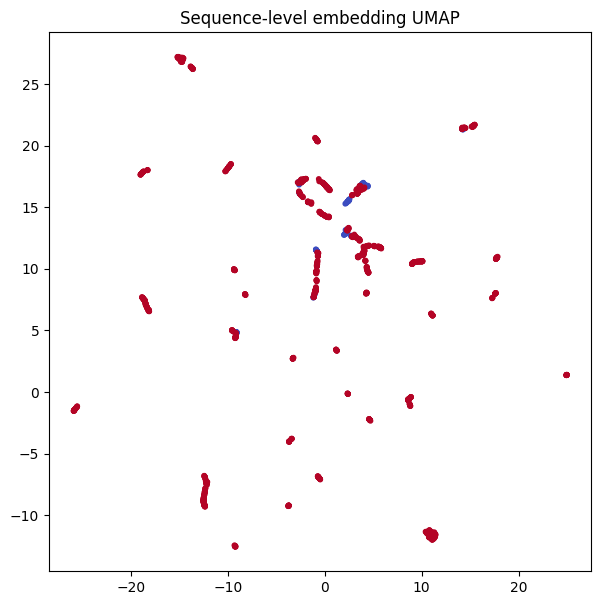

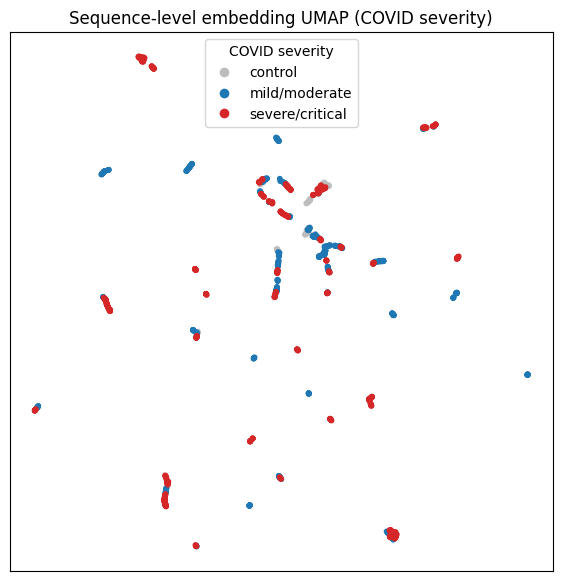

In [32]:
# show for all individuals instead of just test set
embs_100epochs_64seqlen, emb_labels_100epochs_64seqlen = compute_sequence_embeddings(best_model_100epochs_64seqlen, adata)
covid_embeddings_visualize(adata, embs_100epochs_64seqlen, emb_labels_100epochs_64seqlen)

### COVID Severity Prediction

/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/ubuntu/ml4fg-final-project/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== SEVERITY (Multiclass) ===
PCA   ROC-AUC: 0.8569854316586342
MODEL ROC-AUC: 0.8907605466428996


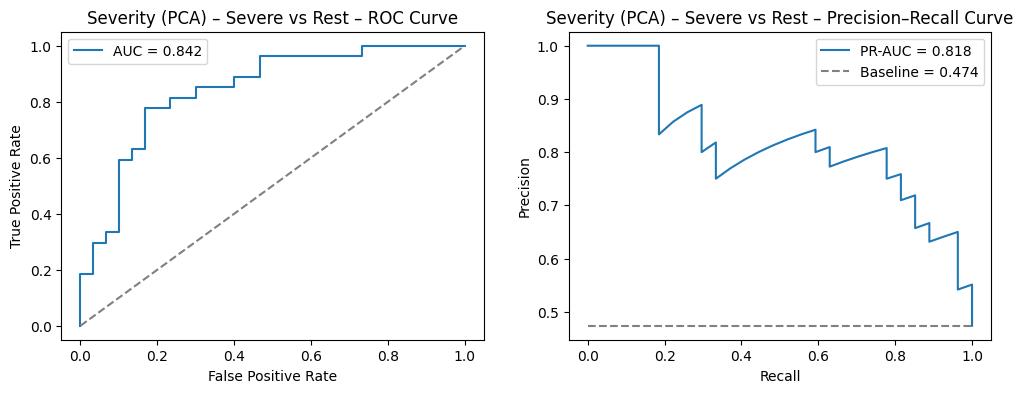

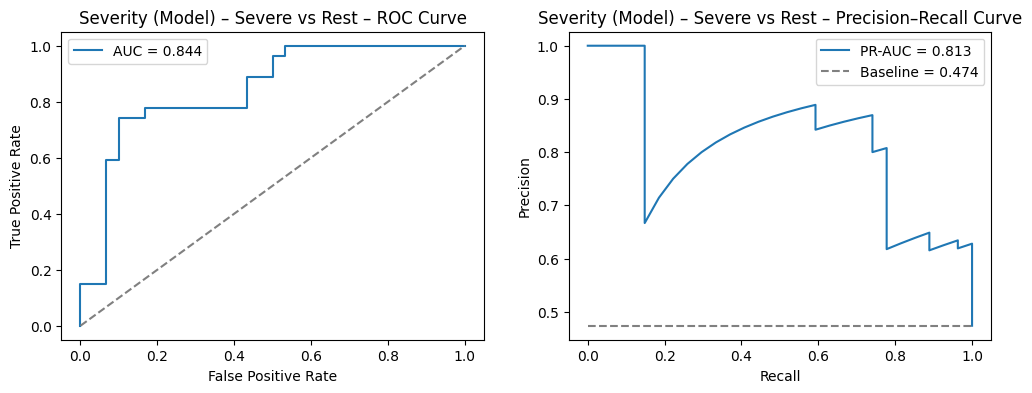

In [33]:
covid_severity_prediction(adata, emb_labels_100epochs_64seqlen, embs_100epochs_64seqlen)

# 50 Epochs, Sequence Length=300

In [ ]:
_, best_model_state_50epochs_500seqlen = train_model(
    adata_train,
    adata_val,
    adata_test,
    device=device,
    seq_len=500, # SEQUENCE LENGTH
    pca_dim = 50, 
    d_model = 256,
    n_layers = 6,
    n_heads = 4,
    d_hid = 512,
    dropout = 0.1,
    n_components = 8,
    max_seq_len = 256,
    batch_size = 32,
    lr = 1e-4,
    epochs = 50, # 50 EPOCHS
    OUTPUT_DIR = Path("/home/ubuntu/ml4fg-final-project/output_models")
    )

number of params: 3383336


### Visualize Results

In [ ]:
best_model_50epochs_500seqlen = AutoregressiveCellModel(
        pca_dim = pca_dim,
        d_model=d_model,
        n_layers = n_layers,
        n_heads = n_heads,
        d_hid = d_hid,
        dropout = dropout,
        n_components = n_components,
        max_seq_len = max_seq_len,
        ).to(device)

checkpoint = torch.load(OUTPUT_DIR / f"best_model_50epochs_500seqlen.pt", map_location=device)
best_model_50epochs_500seqlen.load_state_dict(checkpoint)

visualize_results(adata_test, best_model_50epochs_500seqlen)

In [ ]:
# show for all individuals instead of just test set
embs_50epochs_500seqlen, emb_labels_50epochs_500seqlen = compute_sequence_embeddings(best_model_50epochs_500seqlen, adata)
covid_embeddings_visualize(adata, embs_50epochs_500seqlen, emb_labels_50epochs_500seqlen)

### COVID Severity Prediction

In [ ]:
covid_severity_prediction(adata, emb_labels_50epochs_500seqlen, embs_50epochs_500seqlen)